## 1 - 导包



In [1]:
import numpy as np
import time
from itertools import islice
import math
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

## 2 - readlines方法读取训练数据



In [2]:
'''
输入：
file：数据地址
--------
输出：
data：转换后的数据
label：转换后的标记
'''
def LoadData(file):
    # 打开数据文件
    fr = open(file, 'r')

    # 准备两个list存储data和label
    data = []
    label = []

    # 逐行读取数据，使用islice可以直接跳过第一行表头进行逐行读取
    for line in islice(fr, 1, None):

        # 对每一行消去空格，并根据','进行分割
        splited = line.strip().split(',')

        # 分割后的第一个元素是Label，跳过label遍历所有特征值
        # 归一化
        int_line = [int(num) / 255 for num in splited[1:]]

        # 逐行存储数据
        data.append(int_line)

        # 将问题转换为二分类问题
        if int(splited[0]) == 0:
            label.append(1)
        else:
            label.append(-1)

    # 转换成ndarray形式方便后续计算
    data = np.array(data)
    label = np.array(label)

    # 返回数据的特征部分和标记部分
    return data, label




## 3 - 定义SVM类



In [19]:
class SVM:
    '''初始化参数'''

    def __init__(self, train_data, train_label, sigma, C, toler, itertime):

        self.train_data = train_data  # 训练集数据
        self.train_label = train_label  # 训练集标记
        self.m, self.n = np.shape(train_data)  # self.m为训练集样本容量，self.n为特征数量
        self.sigma = sigma  # 高斯核分母上的超参数
        self.KernalMatrix = self.CalKernalMatrix()  # 高斯核矩阵
        self.alpha = np.zeros(self.m)  # 初始化拉格朗日向量，长度为训练集样本容量
        self.b = 0  # 初始化参数b
        self.C = C  # 惩罚参数
        self.toler = toler  # 松弛变量
        self.itertime = itertime  # 迭代次数
        self.E = [float(-1 * y) for y in self.train_label]  # 初始化Elist，因为alpha和b初始值为0，因此E的初始值为训练集标记的值
        self.learning_rate_history = []  # 记录学习率历史
        self.error_history = []  # 记录误差历史

    '''计算高斯核矩阵'''

    def CalKernalMatrix(self):

        # 初始化高斯核矩阵，矩阵为m*m大小
        KernalMatrix = [[0 for i in range(self.m)] for j in range(self.m)]

        # 遍历每一个样本
        for i in range(self.m):

            # 首先得到一个样本的数据
            X = self.train_data[i]

            # 仅遍历从i到self.m的样本，因为Kij和Kji的值相同，所以只需要计算一次
            for j in range(i, self.m):
                # 得到另一个样本的数据
                Z = self.train_data[j]

                # 计算核函数
                K = np.exp(-1 * np.dot(X - Z, X - Z) / (2 * np.square(self.sigma)))

                # 存储在核矩阵中对称的位置
                KernalMatrix[i][j] = K
                KernalMatrix[j][i] = K

        KernalMatrix = np.array(KernalMatrix)

        return KernalMatrix

    '''计算g(xi)'''

    def Calgxi(self, i):

        Index = [index for index, value in enumerate(self.alpha) if value != 0]
        gxi = 0
        for index in Index:
            gxi += self.alpha[index] * self.train_label[index] * self.KernalMatrix[i][index]
        gxi = gxi + self.b

        return gxi

    '''判断是否符合KKT条件'''

    def isSatisfyKKT(self, i):

        # 获得alpha[i]的值
        alpha_i = self.alpha[i]

        # 计算yi * g(xi)
        gxi = self.Calgxi(i)
        yi = self.train_label[i]
        yi_gxi = yi * gxi

        # 判断是否符合KKT条件
        if -1 * self.toler < alpha_i < self.toler and yi_gxi >= 1:
            return True
        elif -1 * self.toler < alpha_i < self.C + self.toler and math.fabs(yi_gxi - 1) < self.toler:
            return True
        elif self.C - self.toler < alpha_i < self.C + self.toler and yi_gxi <= 1:
            return True
        return False

    '''SMO算法'''

    def SMO(self):

        # 迭代
        t = 0
        parameterchanged = 1
        while t < self.itertime and parameterchanged > 0:

            t += 1
            parameterchanged = 0
            '''选择两个alpha'''

            # 外层循环，选择第一个alpha
            for i in range(self.m):

                # 判断是否符合KKT条件，如果不满足，则选择该alpha为alpha1
                # 如果满足，则继续外层循环
                TorF = self.isSatisfyKKT(i)
                if TorF == False:
                    alpha1 = self.alpha[i]

                    # 从Earray得到alpha1对应的E1
                    E1 = self.E[i]

                    # 复制一个EMatrix，并令E1的位置为nan
                    # 这样在接下来找最大值和最小值时将不会考虑E1
                    # 这里需要使用copy，如果不用copy，改变EM_temp也会同时改变EMatrix
                    EM_temp = np.copy(self.E)
                    EM_temp[i] = np.nan

                    # 我们需要使|E1-E2|的值最大，由此选择E2
                    # 首先初始化maxE1_E2和E2及E2的下标j
                    maxE1_E2 = -1
                    E2 = np.nan
                    j = -1

                    # 内层循环
                    # 遍历EM_temp中的每一个Ei，得到使|E1-E2|最大的E和它的下标
                    for j_temp, Ej in enumerate(EM_temp):
                        if math.fabs(E1 - Ej) > maxE1_E2:
                            maxE1_E2 = math.fabs(E1 - Ej)
                            E2 = Ej
                            j = j_temp

                    # alpha2为E2对应的alpha
                    alpha2 = self.alpha[j]

                    '''求最优alpha1和alpha2'''

                    y1 = self.train_label[i]
                    y2 = self.train_label[j]

                    # 计算η
                    K11 = self.KernalMatrix[i][i]
                    K22 = self.KernalMatrix[j][j]
                    K12 = self.KernalMatrix[i][j]
                    eta = K11 + K22 - 2 * K12

                    # 计算alpha2_new
                    alpha2_new = alpha2 + y2 * (E1 - E2) / eta

                    # 计算上限H和下限L
                    if y1 != y2:
                        L = max([0, alpha2 - alpha1])
                        H = min([self.C, self.C + alpha2 - alpha1])
                    else:
                        L = max([0, alpha2 + alpha1 - self.C])
                        H = min([self.C, alpha2 + alpha1])

                    # 剪切alpha2_new
                    if alpha2_new > H:
                        alpha2_new = H
                    elif alpha2_new < L:
                        alpha2_new = L

                    # 得到alpha1_new
                    alpha1_new = alpha1 + y1 * y2 * (alpha2 - alpha2_new)

                    '''更新b'''
                    # 计算b1_new和b2_new
                    b1_new = -1 * E1 - y1 * K11 * (alpha1_new - alpha1) \
                             - y2 * K12 * (alpha2_new - alpha2) + self.b
                    b2_new = -1 * E2 - y1 * K12 * (alpha1_new - alpha1) \
                             - y2 * K22 * (alpha2_new - alpha2) + self.b

                    # 根据alpha1和alpha2的范围确定b_new
                    if 0 < alpha1_new < self.C and 0 < alpha2_new < self.C:
                        b_new = b1_new
                    else:
                        b_new = (b1_new + b2_new) / 2

                    '''更新E'''
                    # 首先需要更新两个alpha和b
                    self.alpha[i] = alpha1_new
                    self.alpha[j] = alpha2_new
                    self.b = b_new

                    # 计算Ei_new和Ej_new
                    E1_new = self.Calgxi(i) - y1
                    E2_new = self.Calgxi(j) - y2

                    # 更新E
                    self.E[i] = E1_new
                    self.E[j] = E2_new

                    if math.fabs(alpha2_new - alpha2) >= 0.000001:
                        parameterchanged += 1

            print('itertime: %a   parameterchanged: %a' % (t, parameterchanged))

            # 记录学习率和误差
            self.learning_rate_history.append(parameterchanged)
            error = sum([self.Calgxi(i) - self.train_label[i] for i in range(self.m)]) / self.m
            self.error_history.append(error)

        # 最后遍历一遍alpha，大于0的下标即对应支持向量
        VecIndex = [index for index, value in enumerate(self.alpha) if value > 0]

        # 返回支持向量的下标，之后在预测时还需要用到
        return VecIndex

    '''计算b'''

    def OptimizeB(self):

        for j, a in enumerate(self.alpha):
            if 0 < a < self.C:
                break

        yj = self.train_label[j]
        summary = 0
        for i in range(self.alpha):
            summary += self.alpha[i] * self.train_label[i] * self.KernalMatrix[i][j]

        optimiezedB = yj - summary
        self.b = optimiezedB

    '''计算单个核函数'''

    def CalSingleKernal(self, x, z):

        SingleKernal = np.exp(-1 * np.dot(x - z, x - z) / (2 * np.square(self.sigma)))
        return SingleKernal

    '''单个新输入实例的预测'''

    def predict(self, x, VecIndex):

        # 决策函数计算
        # 求和项初始化
        summary = 0

        # Index中存储着不为0的alpha的下标
        for i in VecIndex:
            alphai = self.alpha[i]
            yi = self.train_label[i]
            Kernali = self.CalSingleKernal(x, self.train_data[i])

            summary += alphai * yi * Kernali

        # 最后+b
        # np.sign得到符号
        result = np.sign(summary + self.b)

        return result

    '''测试模型'''

    def test(self, test_data, test_label, VecIndex):

        # 测试集实例数量
        TestNum = len(test_label)

        errorCnt = 0
        y_true = []
        y_scores = []

        # 对每一个实例进行预测
        for i in range(TestNum):
            result = self.predict(test_data[i], VecIndex)
            y_true.append(test_label[i])
            y_scores.append(self.Calgxi(i))
            if result != test_label[i]:
                errorCnt += 1

        Acc = 1 - errorCnt / TestNum

        # 计算并绘制ROC曲线
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('SVM-Receiver Operating Characteristic-王靖策')
        plt.legend(loc="lower right")
        plt.show()

        return Acc


## 定义绘制核矩阵热图方法

In [14]:
def plot_kernal_matrix_heatmap(svm):
    plt.figure()
    plt.imshow(svm.KernalMatrix, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title('SVM-Kernal Matrix Heatmap-王靖策')
    plt.show()

## 定义绘制学习率和误差曲线方法

In [15]:
def plot_learning_rate_and_error(svm):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.plot(svm.learning_rate_history, label='Learning Rate')
    plt.xlabel('Iteration')
    plt.ylabel('Learning Rate')
    plt.title('SVM-Learning Rate-王靖策')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(svm.error_history, label='Error', color='red')
    plt.xlabel('Iteration')
    plt.ylabel('Error')
    plt.title('SVM-Error-王靖策')
    plt.legend()

    plt.show()

## 4 - 训练与测试模型



In [6]:

print('start loading')
# 输入训练集
train_data, train_label = LoadData('fashion-mnist_train.csv')

# 输入测试集
test_data, test_label = LoadData('fashion-mnist_test.csv')
print('end loading')

# 初始化
print('start initiating')
start = time.time()
svm = SVM(train_data[0:10000], train_label[0:10000], 10, 200, 0.001, 10)
end = time.time()
print('end initiating')
print('initiating time: ', end - start)

# 开始SMO算法
print('start training')
start = time.time()
VecIndex = svm.SMO()
end = time.time()
print('end training')
print('training time: ', end - start)

start loading
end loading
start initiating
end initiating
initiating time:  317.33314967155457
start training
itertime: 1   parameterchanged: 615
itertime: 2   parameterchanged: 837
itertime: 3   parameterchanged: 920
itertime: 4   parameterchanged: 897
itertime: 5   parameterchanged: 924
itertime: 6   parameterchanged: 903
itertime: 7   parameterchanged: 938
itertime: 8   parameterchanged: 994
itertime: 9   parameterchanged: 1003
itertime: 10   parameterchanged: 974
end training
training time:  716.3343710899353


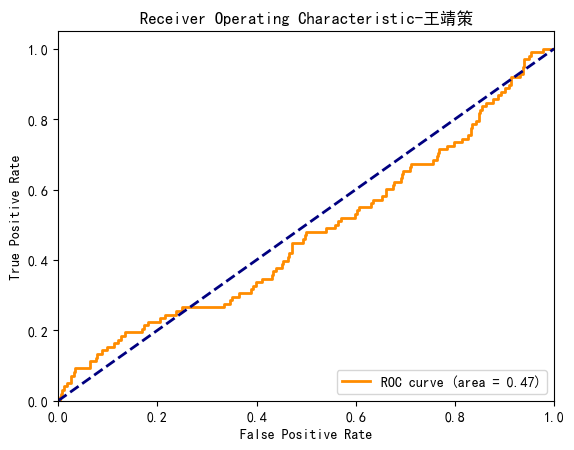

Accurate:  0.953


In [20]:
# 开始测试模型
plt.rcParams['font.sans-serif'] = ['SimHei']  # 或者使用其他支持中文的字体
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号
Acc = svm.test(test_data[0:1000], test_label[0:1000], VecIndex)
print('Accurate: ', Acc)

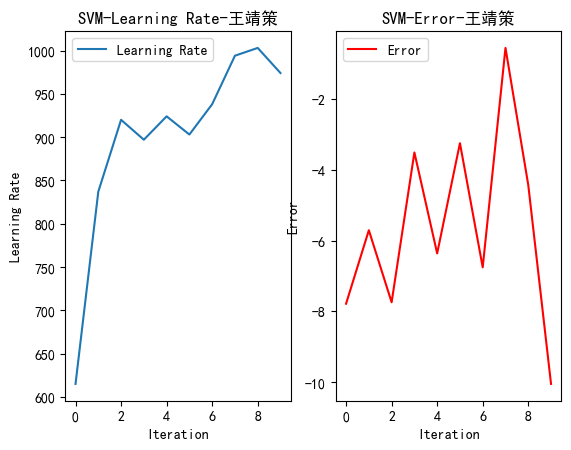

In [17]:
 # 绘制学习率和误差曲线
plot_learning_rate_and_error(svm)


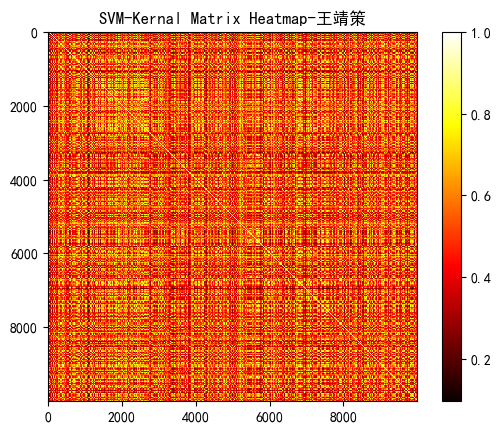

In [18]:
# 绘制核矩阵热图
plot_kernal_matrix_heatmap(svm)